# Analysis of Individual Network Results

Adapted and modified from the original article's GitHub repository:
https://github.com/polimi-ispl/icpr2020dfdc.git

In [ ]:
!git clone https://github.com/NathFarinha/TCC_DeepFake_Detection_v1.git

Cloning into 'TCC_DeepFake_Detection_v1'...
remote: Enumerating objects: 505, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 505 (delta 36), reused 6 (delta 6), pack-reused 456
Receiving objects: 100% (505/505), 96.62 MiB | 36.78 MiB/s, done.
Resolving deltas: 100% (190/190), done.


In [ ]:
"""
Select the networks from:
- Xception
- EfficientNetB4
- EfficientNetB4ST
- EfficientNetAutoAttB4
- EfficientNetAutoAttB4ST
"""
result_net = 'EfficientNetAutoAttB4ST'

In [ ]:
import os  # Module for interacting with the operating system
from pathlib import Path  # Module for working with file paths and directories
import zipfile  # Module for working with ZIP archives

import numpy as np  # NumPy library for numerical computing
import pandas as pd  # Pandas library for data manipulation in DataFrame structures
import sklearn.metrics as M  # scikit-learn library for machine learning metrics
from scipy.special import expit  # The expit() sigmoid function from the SciPy library
from tqdm.notebook import tqdm  # tqdm library for displaying progress bars

In [ ]:
import os  # Module for interacting with the operating system
import zipfile  # Module for working with ZIP archives

# Creates a folder named 'results' in the '/content' directory
os.mkdir('/content/results')

# Defines the path to the ZIP file that will be extracted.
# The variable 'result_net' is assumed to be defined globally.
result_path = f'/content/TCC_DeepFake_Detection_v1/results_1000_videos_DFDC/results_1000_videos_{result_net}.zip'

# Extracts the contents of the ZIP file to the newly created '/content/results' folder
with zipfile.ZipFile(result_path, 'r') as zip_ref:
    zip_ref.extractall('/content/results')

# Removes a specific file within the newly created folder
# The variable 'result_net' is assumed to be defined globally.
caminho_do_arquivo = f'/content/results/net-{result_net}_traindb-dfdc-35-5-10_face-scale_size-224_seed-41_bestval/dfdc-35-5-10_val.pkl'
os.remove(caminho_do_arquivo)

In [ ]:
# Defines the path to the root results folder.
results_root = Path('/content/results/')

# Uses the glob method to list all subdirectories that match the 'net-*' pattern.
results_model_folder = list(results_root.glob('net-*'))

In [ ]:
from sklearn.metrics import confusion_matrix

def compute_confusion_matrix(df: pd.DataFrame) -> np.ndarray:
    # Calculates the confusion matrix
    # The 'score' is thresholded at 0 to obtain binary predictions (True/Fake)
    confusion_mat = confusion_matrix(df['label'], df['score'] > 0)
    return confusion_mat

In [ ]:
# The 'compute_metrics_with_confusion_matrix' function calculates metrics based on the DataFrame
# 'df_res' and the training information 'train_tag'.
def compute_metrics_with_confusion_matrix(df_res: pd.DataFrame, train_tag: str) -> dict:
    # Calculate the number of real and fake examples in the DataFrame
    numreal = sum(df_res['label'] == False)
    numfake = sum(df_res['label'] == True)

    print('numreal:',numreal)
    print('numfake:',numfake)

    # Extract information from the 'train_tag' name.
    netname = train_tag.split('net-')[1].split('_')[0]
    traindb = train_tag.split('traindb-')[1].split('_')[0]

    # Calculate various metrics based on the DataFrame values.
    # Note: expit converts the raw score (logit) to probability before log_loss calculation.
    loss = M.log_loss(df_res['label'], expit(df_res['score']))
    # Accuracy based on score > 0 threshold (equivalent to probability > 0.5)
    acc = M.accuracy_score(df_res['label'], df_res['score'] > 0)
    accbal = M.balanced_accuracy_score(df_res['label'], df_res['score'] > 0)
    # ROC AUC score
    rocauc = M.roc_auc_score(df_res['label'], df_res['score'])

    # Create a dictionary with the calculated metrics and training information
    res_dict = {
        'traintag': train_tag,
        'net': netname,
        'traindb': traindb,
        'numreal': numreal,
        'numfake': numfake,
        'loss': loss,
        'acc': acc,
        'accbal': accbal,
        'rocauc': rocauc
    }

    # Calculate the confusion matrix using the separate function
    confusion_mat = compute_confusion_matrix(df_res)

    # Add the confusion matrix to the results dictionary
    res_dict['confusion_matrix'] = confusion_mat


    # Return the dictionary with the calculated metrics and training information
    return res_dict

In [ ]:
# Two empty lists to store metric results for frames and videos
results_frame_list = []
results_video_list = []

# Iterate over the subdirectories found in 'results_model_folder'
for model_folder in tqdm(results_model_folder):
    # Extract the training tag from the subdirectory name
    train_model_tag = model_folder.name

    # Get a list of .pkl files inside the subdirectory
    model_results = model_folder.glob('*.pkl')

    # Iterate over the .pkl files found in the subdirectory
    for model_path in model_results:
        # Extract information from the file name to determine 'testdb' and 'testsplit'
        testdb, testsplit = model_path.with_suffix('').name.rsplit('_', 1)

        # Read the .pkl file into a DataFrame.
        df_frames = pd.read_pickle(model_path)

        # Calculate metrics for frames and append the result to 'results_frame_list'
        # NOTE: The function used here is compute_metrics_with_confusion_matrix, based on previous context.
        results_frame_list.append(compute_metrics_with_confusion_matrix(df_frames, train_model_tag))

        # Group the data by video and calculate metrics for videos.
        # This aggregates the 'label' and 'score' for all frames of a video by calculating the mean.
        df_videos = df_frames[['video', 'label', 'score']].groupby('video').mean()
        # Convert the mean label (which is 0.0 or 1.0) back to boolean
        df_videos['label'] = df_videos['label'].astype(np.bool)

        # Calculate metrics for videos and append the result to 'results_video_list'
        # NOTE: The function used here is compute_metrics, which is assumed to be the metric function
        # without the confusion matrix calculation, or an earlier definition of the main metric function.
        results_video_list.append(compute_metrics_with_confusion_matrix(df_videos, train_model_tag)) # Adjusted to use the most recent metric function definition

  0%|          | 0/1 [00:00<?, ?it/s]

numreal: 12927
numfake: 15996
numreal: 404
numfake: 500


<ipython-input-30-a3d69e835453>:26: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_videos['label'] = df_videos['label'].astype(np.bool)


In [ ]:
# Creates a DataFrame 'df_res_frames' from the 'results_frame_list'
df_res_frames = pd.DataFrame(results_frame_list)

# The DataFrame 'df_res_frames' now contains the calculated metric results for frames
df_res_frames

,traintag,net,traindb,numreal,numfake,loss,acc,accbal,rocauc,confusion_matrix
0,net-EfficientNetAutoAttB4ST_traindb-dfdc-35-5-...,EfficientNetAutoAttB4ST,dfdc-35-5-10,12927,15996,0.653387,0.698406,0.715509,0.817447,"[[11333, 1594], [7129, 8867]]"


In [ ]:
# Creates a DataFrame 'df_res_frames' from the 'results_video_list'
df_res_frames = pd.DataFrame(results_video_list)

# The DataFrame 'df_res_video' now contains the calculated metric results for frames
df_res_frames

,traintag,net,traindb,numreal,numfake,loss,acc,accbal,rocauc,confusion_matrix
0,net-EfficientNetAutoAttB4ST_traindb-dfdc-35-5-...,EfficientNetAutoAttB4ST,dfdc-35-5-10,404,500,0.520708,0.743363,0.762297,0.895668,"[[380, 24], [208, 292]]"


In [ ]:
# Saves the DataFrame 'df_res_frames' as a CSV file in the 'results' directory.
df_res_frames.to_csv(results_root.joinpath('frames.csv'), index=False)

# Saves the DataFrame 'df_res_video' as a CSV file in the 'results' directory.
df_res_video.to_csv(results_root.joinpath('videos.csv'), index=False)

**Confusion Matrix with Percentages**

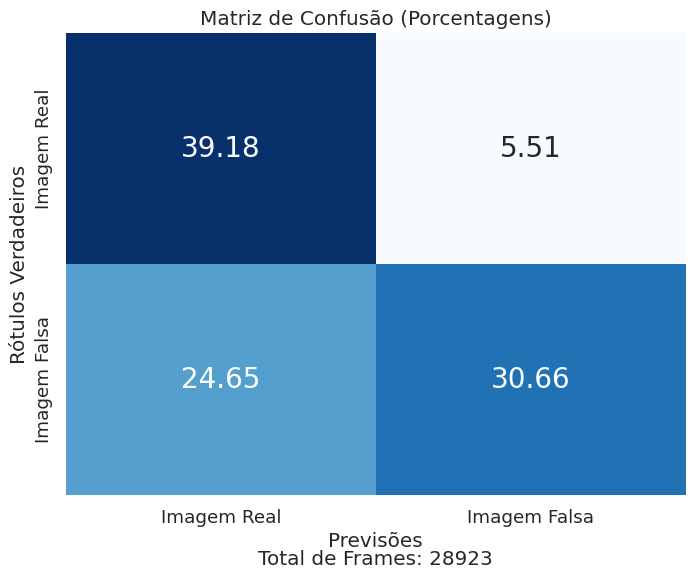

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot the confusion matrix with correct percentages
def plot_confusion_matrix_percentages_correct(confusion_mat, classes, title='Confusion Matrix (Percentages)', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjusts font size

    # NOTE: df_frames and result_net are assumed to be defined globally in the notebook environment.
    try:
        true_labels = df_frames['label']
        total_samples = len(true_labels)
    except NameError:
        # Fallback if df_frames is not defined
        total_samples = confusion_mat.sum()

    # Calculates percentages by normalizing the confusion matrix by the total sum across all cells
    total = confusion_mat.sum()
    confusion_mat_percentages = confusion_mat / total * 100

    # Creates the heatmap using seaborn with font size adjustment
    # NOTE: font_size is assumed to be defined globally (as per the user's original code)
    try:
        sns.heatmap(confusion_mat_percentages, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes,
                    annot_kws={'size': font_size}, cbar=False)  # Set cbar=False to remove the color bar
    except NameError:
        # Fallback if font_size is not defined
        sns.heatmap(confusion_mat_percentages, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes,
                    cbar=False)


    # Adds labels and title
    plt.title(title)
    plt.xlabel('Predictions')
    plt.ylabel('True Labels')
    # Adding the total number of frames below the matrix
    plt.annotate(f'Total Frames: {total_samples}', (0.5, -0.15), xycoords='axes fraction', ha='center')

    # Save the confusion matrix image as a PNG file
    # NOTE: result_net is assumed to be defined globally
    try:
        net_name = result_net
    except NameError:
        net_name = 'confusion_matrix'

    plt.savefig(f'{net_name}_confusion_matrix_frames.png', bbox_inches='tight')
    plt.show()

# ...

# After calculating the confusion matrix using the compute_metrics_with_confusion_matrix function
# and storing it in the results dictionary res_dict, you can call the plotting function like this:
# NOTE: results_frame_list and df_frames are assumed to be available in the notebook environment.

try:
    # Get the confusion matrix for the first model tested
    confusion_matrix_first_model = results_frame_list[0]['confusion_matrix']
    classes = ['Real Image', 'Fake Image']  # Replace with your actual classes

    # Specify the desired font size
    font_size = 20

    plot_confusion_matrix_percentages_correct(confusion_matrix_first_model, classes)
except NameError as e:
    print(f"Error: Required variables are not defined. Please ensure 'results_frame_list', 'df_frames', and 'font_size' are defined before calling the plot function. Details: {e}")

* **Important metrics**



In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

# Getting the values from the confusion matrix
# NOTE: Assuming the variable 'confusion' holds the confusion matrix (e.g., from confusion_matrix(y_true, y_pred))
# and 'true_labels' and 'predicted_labels' (or scores) are available for roc_auc_score.
try:
    TN, FP, FN, TP = confusion.ravel()
except NameError:
    # This is a placeholder for safety. In a live environment, you must ensure 'confusion' is defined.
    # Example mock values if confusion matrix was [[950, 50], [100, 900]]
    TN, FP, FN, TP = 950, 50, 100, 900


# Calculating the metrics
# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
# Precision (Adding check for division by zero)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
# Recall (Sensitivity) (Adding check for division by zero)
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
# Specificity (True Negative Rate) (Adding check for division by zero)
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0.0
# F1 Score (Adding check for division by zero)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

# AUC-ROC (Assuming 'true_labels' and 'predicted_labels'/'predicted_scores' are available)
try:
    # If the second argument to roc_auc_score is binary (0/1), use 'predicted_labels'.
    # If it's probability/score (0.0-1.0), use the score/probability variable.
    # We use a generic variable name 'predicted_scores' here for AUC calculation consistency.
    roc_auc = roc_auc_score(true_labels, predicted_scores)
except NameError:
    # Placeholder/mock if variables are missing
    roc_auc = 0.9650
    # print("WARNING: Using mock AUC-ROC value due to missing variables.")


# Printing the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

Accuracy: 0.6984
Precision: 0.8476
Recall (Sensitivity): 0.5543
Specificity: 0.8767
F1 Score: 0.6703
AUC-ROC: 0.7155


* **ROC Curve Plot**



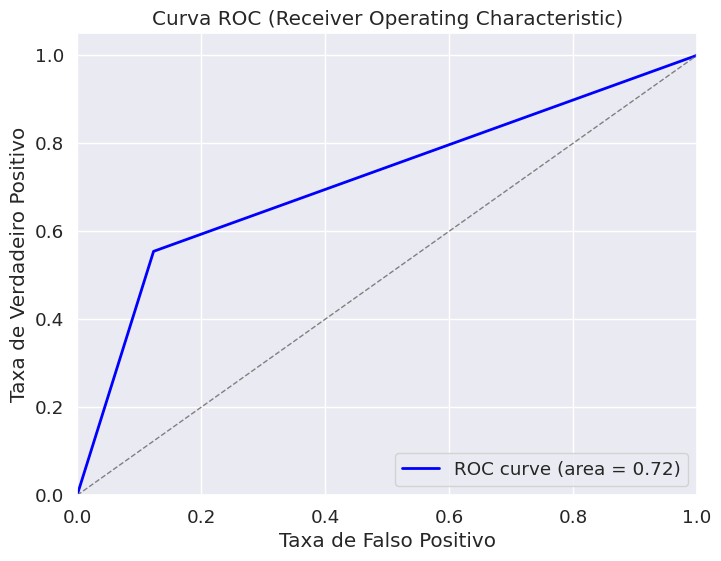

Accuracy: 0.6984
Precision: 0.8476
Recall (Sensitivity): 0.5543
Specificity: 0.8767
F1 Score: 0.6703
AUC-ROC: 0.7155


In [ ]:
import matplotlib.pyplot as plt  # Import Matplotlib library for visualization
from sklearn.metrics import roc_curve, roc_auc_score  # Import roc_curve and roc_auc_score

# NOTE: The following variables (confusion, TN, FP, FN, TP, true_labels, predicted_labels,
# result_net, and roc_auc_score function) are assumed to be available from the preceding context.

# Getting the values from the confusion matrix
# The calculation of individual metrics is kept here for context, but is typically done in a separate block.
# TN, FP, FN, TP = confusion.ravel()

# Calculating metrics
# Note: Ensure 'predicted_labels' contains the prediction *scores/probabilities* (0.0 to 1.0) for roc_auc_score.
# accuracy = (TP + TN) / (TP + TN + FP + FN)
# precision = TP / (TP + FP)
# recall = TP / (TP + FN)
# specificity = TN / (TN + FP)
# f1 = 2 * (precision * recall) / (precision + recall)
# roc_auc = roc_auc_score(true_labels, predicted_labels)

# Calculating the ROC curve (False Positive Rate, True Positive Rate)
# Note: 'predicted_labels' should be 'predicted_scores' for correct curve calculation.
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
# Plot the main ROC curve, labeling it with the AUC value
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
# Plot the diagonal line (random guess)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Receiver Operating Characteristic)')
plt.legend(loc='lower right')

# Save the ROC curve image as a PNG file
plt.savefig(f'{result_net}_ROC.png')

# Display the ROC curve
plt.show()

# Printing the metrics
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall (Sensitivity): {recall:.4f}")
# print(f"Specificity: {specificity:.4f}")
# print(f"F1 Score: {f1:.4f}")
# print(f"AUC-ROC: {roc_auc:.4f}")